In [2]:
import tensorflow as tf
from keras import models, layers
import matplotlib.pyplot as plt


In [3]:
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS=3
EPOCHS=50

In [4]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(r"C:\Users\vedant raikar\Desktop\plant disease\cornmaize\dataset corn",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE
)


Found 3852 files belonging to 4 classes.


In [5]:
class_names = dataset.class_names
class_names


['Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot',
 'Corn_(maize)___Common_rust_',
 'Corn_(maize)___Northern_Leaf_Blight',
 'Corn_(maize)___healthy']

In [6]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())


(32, 256, 256, 3)
[1 1 2 3 1 3 3 3 3 2 3 1 0 3 0 1 3 2 1 2 0 2 2 1 3 3 2 2 1 0 1 3]


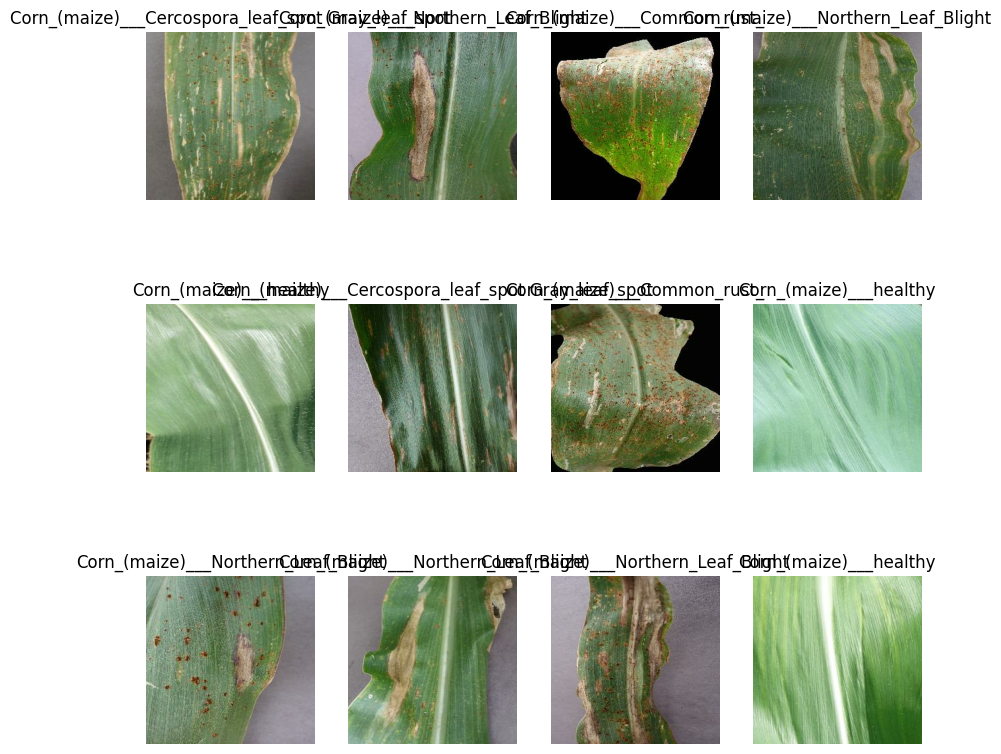

In [10]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")


In [7]:
len(dataset)


121

In [8]:
train_size = 0.8
len(dataset)*train_size


96.80000000000001

In [9]:
train_ds = dataset.take(96)

In [11]:
len(train_ds)


96

In [16]:
test_ds = dataset.skip(96)
len(test_ds)


25

In [17]:
val_size = 0.1
len(dataset)*val_size


12.100000000000001

In [18]:
val_ds = test_ds.take(12)
len(val_ds)


12

In [19]:
test_ds = test_ds.skip(12)
len(test_ds)

13

In [20]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1

    ds_size = len(ds)

    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)

    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)

    return train_ds, val_ds, test_ds


In [21]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)


In [22]:
len(train_ds)


96

In [23]:
len(val_ds)

12

In [24]:
len(test_ds)

13

In [25]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)


In [27]:
resize_and_rescale = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    tf.keras.layers.experimental.preprocessing.Rescaling(1./255),
])


In [29]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
])


In [30]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)


Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


In [31]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 4

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size=(3, 3), activation='relu',
                  input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)


In [32]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (32, 127, 127, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (32, 62, 62, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (32, 60, 60, 64)         

In [33]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)


In [34]:
history = model.fit(
    train_ds,
    batch_size = BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=50,

)

Epoch 1/50
96/96 [==============================] - 206s 2s/step - loss: 0.8960 - accuracy: 0.5659 - val_loss: 0.5506 - val_accuracy: 0.6927
Epoch 2/50
96/96 [==============================] - 180s 2s/step - loss: 0.3846 - accuracy: 0.8394 - val_loss: 0.4211 - val_accuracy: 0.8464
Epoch 3/50
96/96 [==============================] - 179s 2s/step - loss: 0.2925 - accuracy: 0.8611 - val_loss: 0.2631 - val_accuracy: 0.8750
Epoch 4/50
96/96 [==============================] - 524s 5s/step - loss: 0.2651 - accuracy: 0.8856 - val_loss: 0.2229 - val_accuracy: 0.8906
Epoch 5/50
96/96 [==============================] - 475s 5s/step - loss: 0.3944 - accuracy: 0.8503 - val_loss: 0.2155 - val_accuracy: 0.8880
Epoch 6/50
96/96 [==============================] - 178s 2s/step - loss: 0.2537 - accuracy: 0.8801 - val_loss: 0.2176 - val_accuracy: 0.8854
Epoch 7/50
96/96 [==============================] - 200s 2s/step - loss: 0.2218 - accuracy: 0.9001 - val_loss: 0.1926 - val_accuracy: 0.9010
Epoch 8/50
96

first image to predict
actual label: Corn_(maize)___Common_rust_
1/1 [==============================] - 1s 1s/step
predicted label: Corn_(maize)___Common_rust_


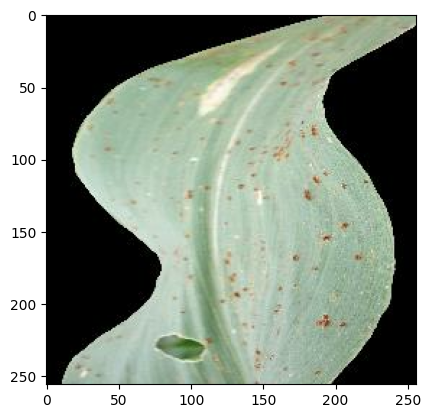

In [35]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [36]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence


1/1 [==============================] - 0s 49ms/step


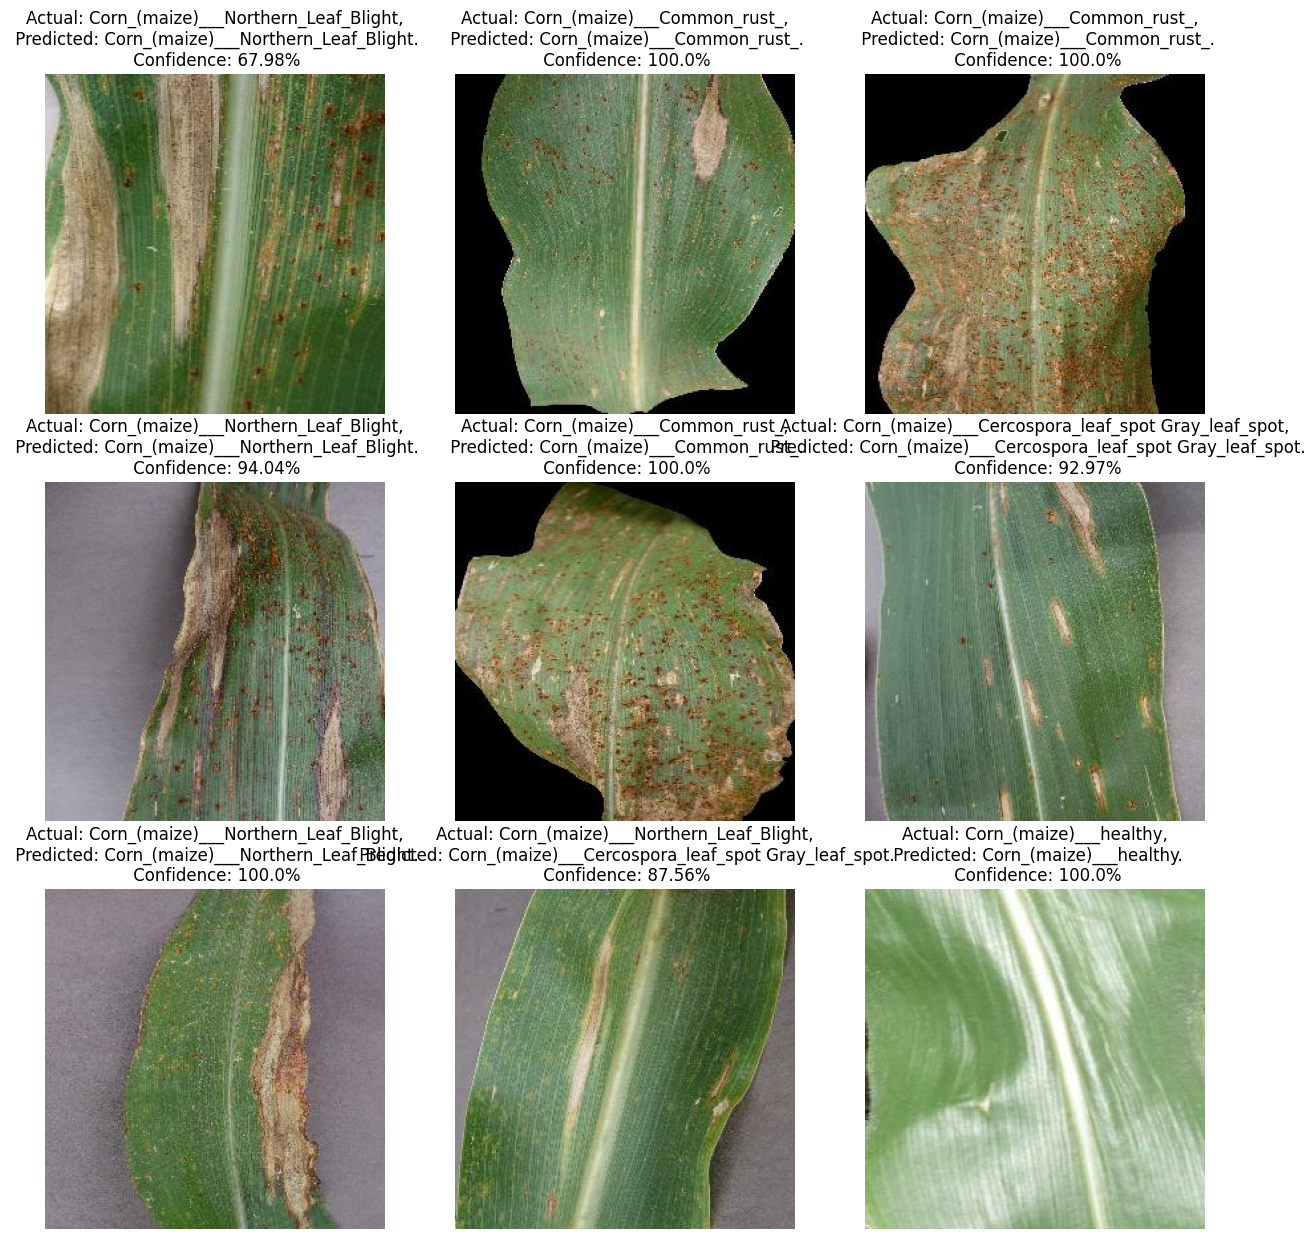

In [37]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))

        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]

        plt.title(
            f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")

        plt.axis("off")


In [38]:
model.save("maize.h5")


In [39]:
model.save("maize.pkl")

INFO:tensorflow:Assets written to: maize.pkl\assets


INFO:tensorflow:Assets written to: maize.pkl\assets
